

<h2 align="center"> Cats vs Dogs </h2>
<h2 align="center" style="color:#01ff84"> Loading your dataset</h2>


<br>

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src="imgs/dog.png" width="200" height="40" />
<img src="imgs/cat.png" width="200" height="40" />

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

<br>

Start importing the needed libraries:

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch import optim


The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). They are already splitted into a training set and test set.

 
>**Exercise:** Download the dataset and place the train and test set in the `datasets/cat_vs_dog` folder. If you're cloning this from github, you should have it in `../datasets/`. So first create the `cat_vs_dog` folder in `datasets` and verify that the data are there by running `ls ../datasets/cat_vs_dog` (or your custom path if you changed it).

Great! Now that you have downloaded your data, you need to define the transformations to be passed to the `ImageFolder` function. You have already used them with the MNIST dataset (see the Data Augmentation workbook in Pytorch). While for MNIST you were passing the transformation in the following line of code

`datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)`

here you do it in the `ImageFolder` method. You can think it as a way to work on every dataset, not only on the MNIST one.


### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. 

As in the other notebook, you can use the following transformations:

```python
transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

```

**WARNING!** Remember that transformation are super useful for "augmenting" your training data, so that you make your network less vulnerable to different sizes, rotations, or cropping. However, when you are on the test data, there is no need of augmenting the data! Actually, it is not a good practice to do that because there would be very repetitive test data that invalidates your score.

For this reason, define two different transformations for training and test data (remember that `ToTensor()` and normalization are necessary also for the test data, as well as the resizing (you can use `transforms.Resize(size)` for it):



In [5]:
train_transform = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])


data_dir = "C:/Users/Abubakr/Documents/Datasets/Cat_Dog_data" # or the path where you have downloaded the dataset

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transform)

Now that you have you have defined the needed transformation, it's time to build the Data loader itself!

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Build the dataloader for both the train and test data. Choose the batch size that fits your memory. 
**Remember** NOT TO shuffle the test data! 

In [6]:
from torch.utils.data import DataLoader
trainloader =  DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)
trainloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

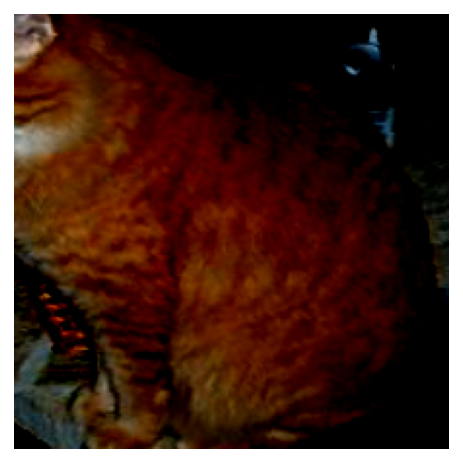

In [7]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


# Run this to test your data loaders
images, labels = next(iter(trainloader))
imshow(images[0], normalize=False)



Ok, now let's create a simple Convolutional Neural Network for this task!

**N.B.** When building a convolutional neural network, be careful for making all the shapes to match.


In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 120) # fc--> fully connected
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


net = Net()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()




Why do we reshape in the middle of the forward pass?

As you remember from the class, the output of a convolutional layer is always a 3D volume! For this reason, since the output channels of the conv2 layer is 16 and the feature maps have size 5x5, then the input of the fc1 layer must be reshaped to have shape `(batch_size, 16 * 5 * 5)`.

Now the question is: what will be the difference in the training of this network with respect to the fully-connected one you are used to?

None, except for the fact that you do not reshape the input to be a vector, but you keep the shape as a volume! 

>**Exercise:** Implement a Convolutional Neural Network for the cat vs dog challenge, such that:
> - The input images have shape 28x28 and three RGB channels
> - You have 2 Conv2d layer with MaxPool2D in the middle and two fully-connected layer at the end.
> - You can decide yourself the rest of the hyperparameters (kernel size, number of filters...)
> - Train and evaluate your model

Following there's an helper function to visualize your prediction once your model has been built.



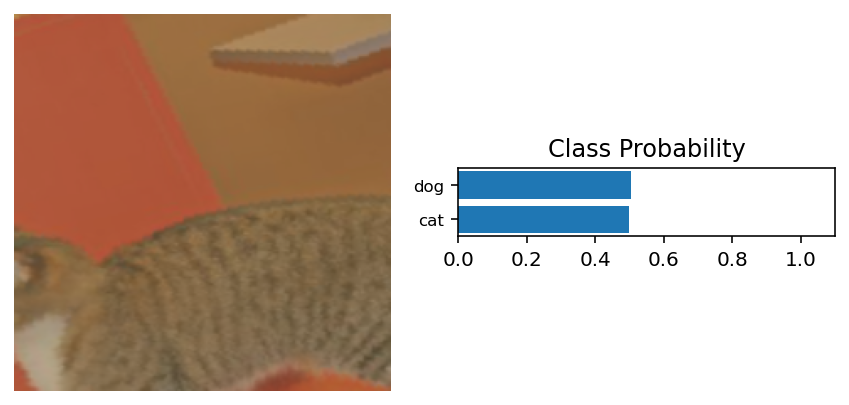

In [21]:
import numpy as np
class_list = train_data.classes

def view_classify_general(img, ps, class_list):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    imshow(img, ax=ax1, normalize=True)
    ax1.axis('off')
    ax2.barh(np.arange(len(class_list)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(class_list)))
    ax2.set_yticklabels([x for x in class_list], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

images, labels = next(iter(trainloader))
img, label = images[0], labels[0]
# Flatten images
# Forward pass, get our logits
logits = net(img.view(1, *images[0].shape))
# Calculate the loss with the logits and the labels
ps = torch.exp(logits)
    
view_classify_general(img, ps, class_list)

You should get something cute like this:

![image](imgs/cat_pred.png)


In [23]:
# YOUR CODE HERE

def torch_fit(trainloader,criterion, lr, num_epochs, model):
    optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)

    train_losses=[]
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        
        train_epoch_loss=[]
        for i,(images,labels) in enumerate(iter(trainloader)):
            print(images.shape)
            images.resize_(images.size()[0], images.size()[2],images.size()[3])
            optimizer.zero_grad()
            output=model.forward(images)
            loss=criterion(output, labels)
            train_epoch_loss.append(loss)
            loss.backward()
            optimizer.step()
        
        train_loss_mean=sum(train_epoch_loss)/len(train_epoch_loss)
        train_losses.append(train_loss_mean)
        print(f'Mean epoch loss for train: {train_loss_mean}')

ans=torch_fit(trainloader=trainloader,criterion=criterion,lr=0.001,num_epochs=5,model=net)


Epoch: 1/5
torch.Size([32, 3, 224, 224])


RuntimeError: Given groups=1, weight of size [32, 3, 5, 5], expected input[1, 32, 224, 224] to have 3 channels, but got 32 channels instead